In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def parse_cons_times(line, pattern="_: "):
    # start_up_lower_bound_ccgt,2030,1,4_4_: -1 units_on_ccgt,2030,1,1_3_ + 1 units_on_ccgt,2030,1,4_6_ - 1 start_up_ccgt,2030,1,4_4_ <= 0
    split = line.split("_: ")
    
    constraint_data = split[0]
    rest = split[1]
    
    split = constraint_data.split(',')
    start_end_times_str = split[-1]
    start_end_times_strings = start_end_times_str.split('_')
    start_time = int(start_end_times_strings[0])
    end_time = int(start_end_times_strings[1]) + 1
    
    return ((start_time, end_time), rest)

In [3]:
def parse_units_on_var_previous_times(line, asset_name, pattern='_ +'):
    # -1 units_on_ccgt,2030,1,1_3_ + 1 units_on_ccgt,2030,1,4_6_ - 1 start_up_ccgt,2030,1,4_4_ <= 0
#     print(line)
    split = line.split(pattern)
#     print(split)        
    
    var_data = split[0]
    rest = split[1]
    
    if len(split) > 2:
        for i in range(2, len(split)):
            rest += "_ -" + split[i]
            
#     print(rest)
    
    if not asset_name in var_data:
        return ""
    
    split = var_data.split(',')
    start_end_times_str = split[-1]
    start_end_times_strings = start_end_times_str.split('_')
    start_time = int(start_end_times_strings[0])
    end_time = int(start_end_times_strings[1]) + 1
    
    return ((start_time, end_time), rest)

In [4]:
def parse_units_on_var_current_times(line, asset_name, pattern='_ -'):
    # 1 units_on_ccgt,2030,1,4_6_ - 1 start_up_ccgt,2030,1,4_4_ <= 0
    split = line.split(pattern)
    
    var_data = split[0]
    rest = split[1]
    
    if not asset_name in var_data:
        return ""
    
    split = var_data.split(',')
    start_end_times_str = split[-1]
    start_end_times_strings = start_end_times_str.split('_')
    start_time = int(start_end_times_strings[0])
    end_time = int(start_end_times_strings[1]) + 1
    
    return ((start_time, end_time), rest)

In [5]:
def parse_start_up_var_times(line, asset_name):
    # 1 start_up_ccgt,2030,1,4_4_ <= 0
    split = line.split(' <= ')
    
    var_data = split[0]
    rest = split[1]
    
    if not asset_name in var_data:
        return ""
    
    split = var_data.split(',')
    start_end_times_str = split[-1]
    start_end_times_strings = start_end_times_str.split('_')
    start_time = int(start_end_times_strings[0])
    end_time = int(start_end_times_strings[1]) + 1
    
    return ((start_time, end_time), rest)

In [6]:
def get_asset_name(line):
    first_comma_index = line.find(',')
    
    if first_comma_index == -1:
        return None
    
    return ((line[:first_comma_index]).split('_'))[-1]

In [7]:
constraint_name = 'start_up_lower_bound'
asset_names = ['ccgt', 'ocgt', 'smr']

constraint_name = constraint_name + '_'

In [8]:
asset_times_map = {}

for asset in asset_names:
    asset_times_map[asset] = {
        "cons_start_end_times": [],
        "units_on_var_previous_start_end_times": [],
        "units_on_var_current_start_end_times": [],
        "start_up_var_start_end_times": []
    }

In [9]:
line_number = 0

with open('model.lp', 'r') as file:
    for line in file:
        line_number += 1
        
        asset_name = get_asset_name(line)
        
        if asset_name is None or asset_name not in asset_names:
            continue
        
        if (not constraint_name in line):
            continue
        try:
            (cons_times, rest) = parse_cons_times(line)
            (units_on_var_previous_times, rest) = parse_units_on_var_previous_times(rest, asset_name)
            
            if rest == "":
                print(f"ERROR in line {line_number}: asset != {asset_name}")
                break
            
            (units_on_var_current_times, rest) = parse_units_on_var_current_times(rest, asset_name)
            
            if rest == "":
                print(f"ERROR in line {line_number}: asset != {asset_name}")
                break
            
            (start_up_var_times, rest) = parse_start_up_var_times(rest, asset_name)
            
            if rest == "":
                print(f"ERROR in line {line_number}: asset != {asset_name}")
                break
        
            if rest.rstrip() != "0":
                print(f"ERROR in line {line_number}: RHS != 0; RHS == {rest}")
                break

            asset_times_map[asset_name]["cons_start_end_times"].append(cons_times)
            asset_times_map[asset_name]["units_on_var_previous_start_end_times"].append(units_on_var_previous_times)
            asset_times_map[asset_name]["units_on_var_current_start_end_times"].append(units_on_var_current_times)
            asset_times_map[asset_name]["start_up_var_start_end_times"].append(start_up_var_times)
        except Exception as e:
            print(f"An ERROR occured on LINE: {line_number}: ")
            print(e)
            print(line)
            break
        

In [10]:
colours = ["red", "green", "yellow"]
alphas = [0.7, 0.7, 0.5]
hatches = [None, '///', None]
labels = ["units_on(b - 1)", "units_on(b)", "start_up(b)"]

In [11]:
def plot_constraints(asset_times_map, constraint_name):
    for asset_key in asset_times_map:
        cons_start_end_times = asset_times_map[asset_key]['cons_start_end_times']
        units_on_var_previous_start_end_times = asset_times_map[asset_key]['units_on_var_previous_start_end_times']
        units_on_var_current_start_end_times = asset_times_map[asset_key]['units_on_var_current_start_end_times']
        start_up_var_start_end_times = asset_times_map[asset_key]['start_up_var_start_end_times']

        variables = [units_on_var_previous_start_end_times, units_on_var_current_start_end_times, start_up_var_start_end_times]

        fig, ax = plt.subplots(figsize=(10, 10))

        all_var_times = [t for pair in units_on_var_previous_start_end_times for t in pair]
        all_cons_times = [t for pair in cons_start_end_times for t in pair]

        max_end_time = max([cons_start_end_times[-1][1], units_on_var_previous_start_end_times[-1][1], units_on_var_current_start_end_times[-1][1], start_up_var_start_end_times[-1][1]])

        ax.set_xlim(0, max_end_time + 1)
        ax.set_ylim(0,  max_end_time + 1)

        for (variable, colour, alpha, hatch) in zip(variables, colours, alphas, hatches):
            for ((cons_start, cons_end), (var_start, var_end)) in zip(cons_start_end_times, variable):
                rect = patches.Rectangle((var_start, cons_start), (var_end - var_start), (cons_end - cons_start), linewidth=1, edgecolor='black', facecolor=colour, alpha=alpha, hatch=hatch)
                ax.add_patch(rect)

        x_ticks = sorted(set([t for pair in [*units_on_var_previous_start_end_times, *units_on_var_current_start_end_times, *start_up_var_start_end_times] for t in pair]))
        y_ticks = sorted(set([t for pair in cons_start_end_times for t in pair]))

        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
        legend_patches = [
            patches.Patch(color=colour, alpha=alpha, hatch=hatch, label=label, linewidth=3) for (colour, alpha, hatch, label) in zip (colours, alphas, hatches, labels)
        ]

        ax.legend(handles=legend_patches, loc='upper left')

        ax.set_xlabel("Start and end times for the variables of the constraint [hours]")
        ax.set_ylabel("Start and end times of B-high [hours]")
        ax.set_title(f"Timeblocks considered for the {constraint_name} constraint for the {asset_key} asset")

        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        ax.set_aspect('equal')

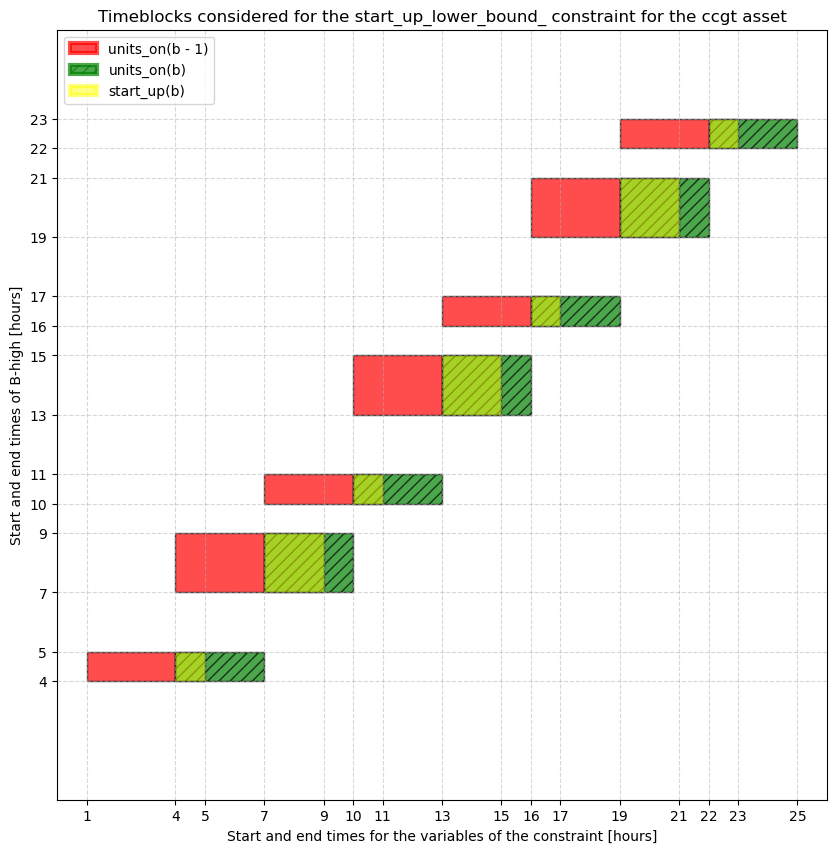

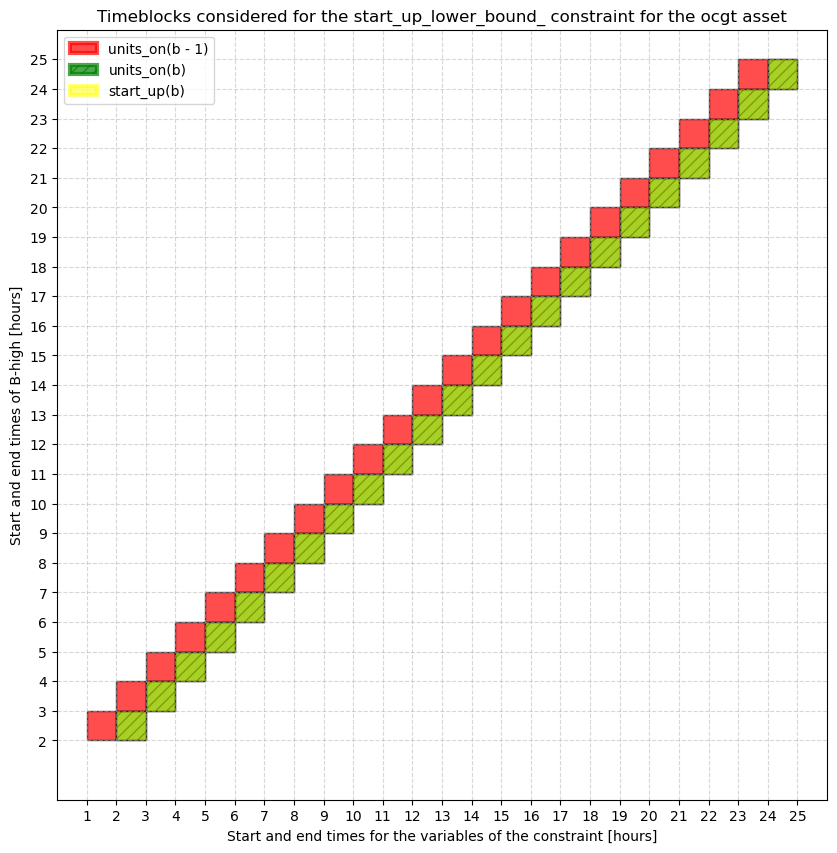

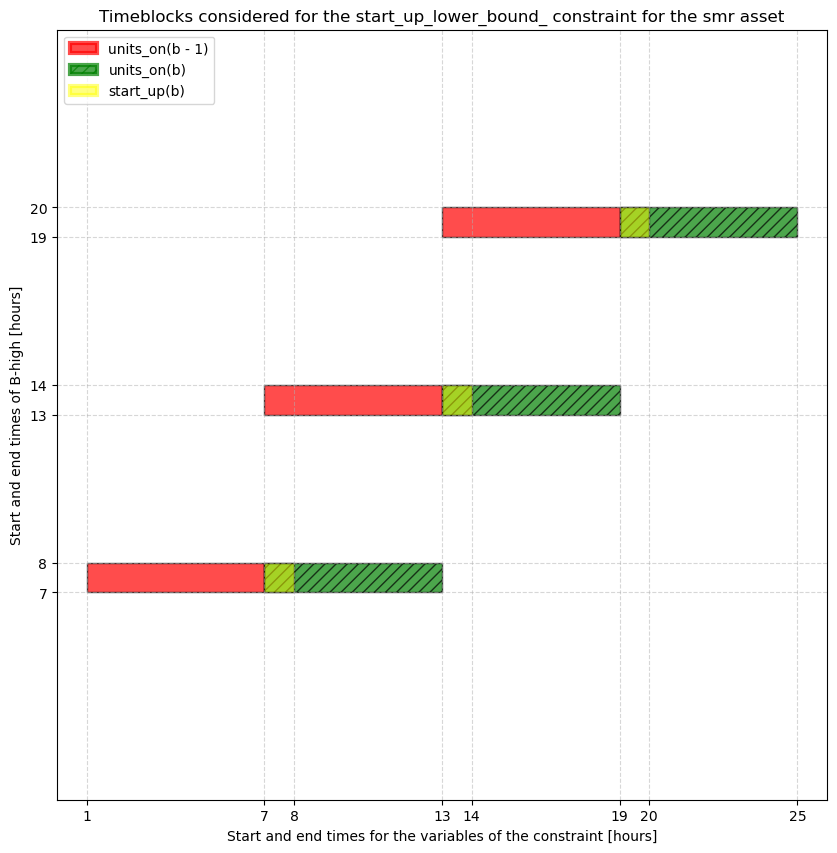

In [12]:
plot_constraints(asset_times_map, constraint_name)

In [13]:
constraint_name = 'shut_down_lower_bound'
asset_names = ['ccgt', 'ocgt', 'smr']

constraint_name = constraint_name + '_'

In [14]:
asset_times_map = {}

for asset in asset_names:
    asset_times_map[asset] = {
        "cons_start_end_times": [],
        "units_on_var_previous_start_end_times": [],
        "units_on_var_current_start_end_times": [],
        "start_up_var_start_end_times": []
    }

In [15]:
line_number = 0

with open('model.lp', 'r') as file:
    for line in file:
        line_number += 1
        
        asset_name = get_asset_name(line)
        
        if asset_name is None or asset_name not in asset_names:
            continue
        
        if (not constraint_name in line):
            continue
        try:
            (cons_times, rest) = parse_cons_times(line, pattern='_: 1')
            (units_on_var_previous_times, rest) = parse_units_on_var_previous_times(rest, asset_name, pattern='_ -')
            
            if rest == "":
                print(f"ERROR in line {line_number}: asset != {asset_name}")
                break
            
            (units_on_var_current_times, rest) = parse_units_on_var_current_times(rest, asset_name, pattern='_ -')
            
            if rest == "":
                print(f"ERROR in line {line_number}: asset != {asset_name}")
                break
            
            (start_up_var_times, rest) = parse_start_up_var_times(rest, asset_name)
            
            if rest == "":
                print(f"ERROR in line {line_number}: asset != {asset_name}")
                break
        
            if rest.rstrip() != "0":
                print(f"ERROR in line {line_number}: RHS != 0; RHS == {rest}")
                break

            asset_times_map[asset_name]["cons_start_end_times"].append(cons_times)
            asset_times_map[asset_name]["units_on_var_previous_start_end_times"].append(units_on_var_previous_times)
            asset_times_map[asset_name]["units_on_var_current_start_end_times"].append(units_on_var_current_times)
            asset_times_map[asset_name]["start_up_var_start_end_times"].append(start_up_var_times)
        except Exception as e:
            print(f"An ERROR occured on LINE: {line_number}: ")
            print(e)
            print(line)
            
            raise e
            break
        

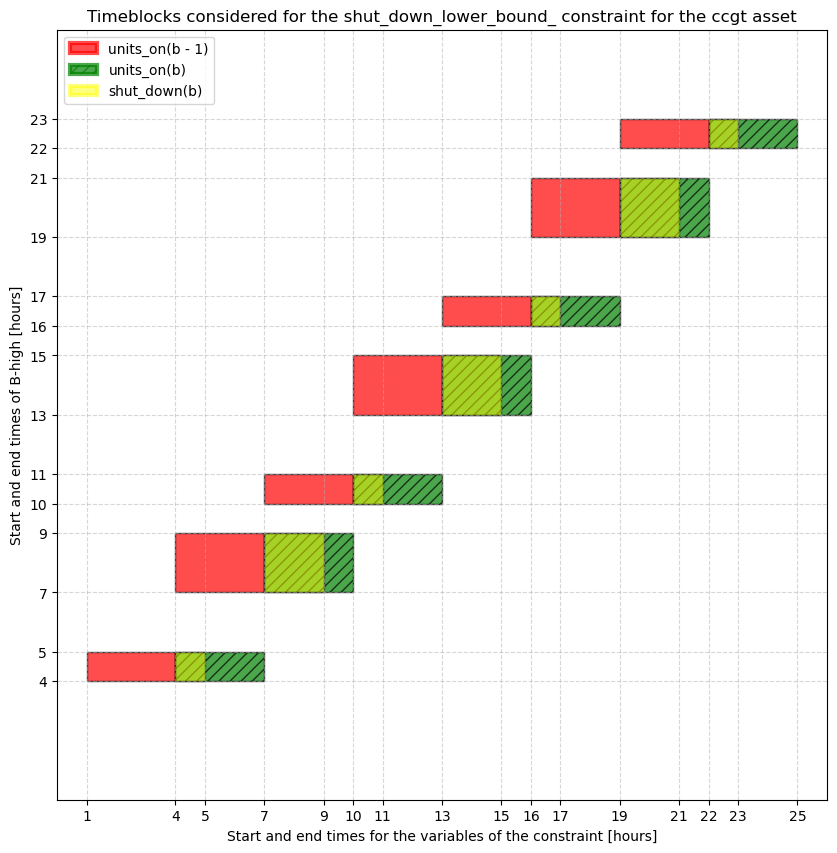

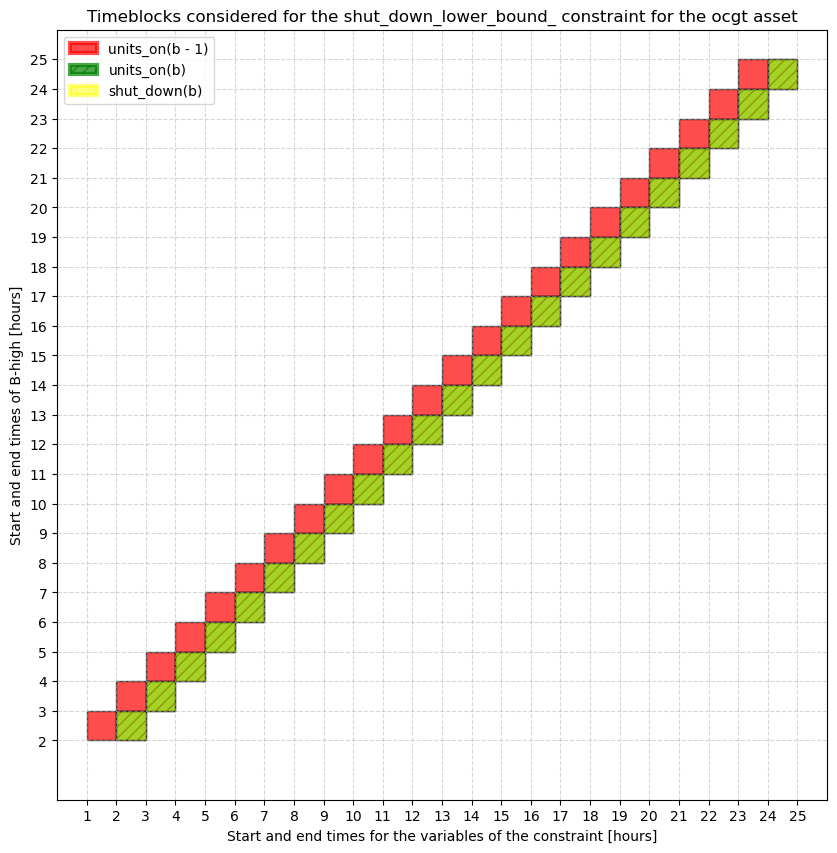

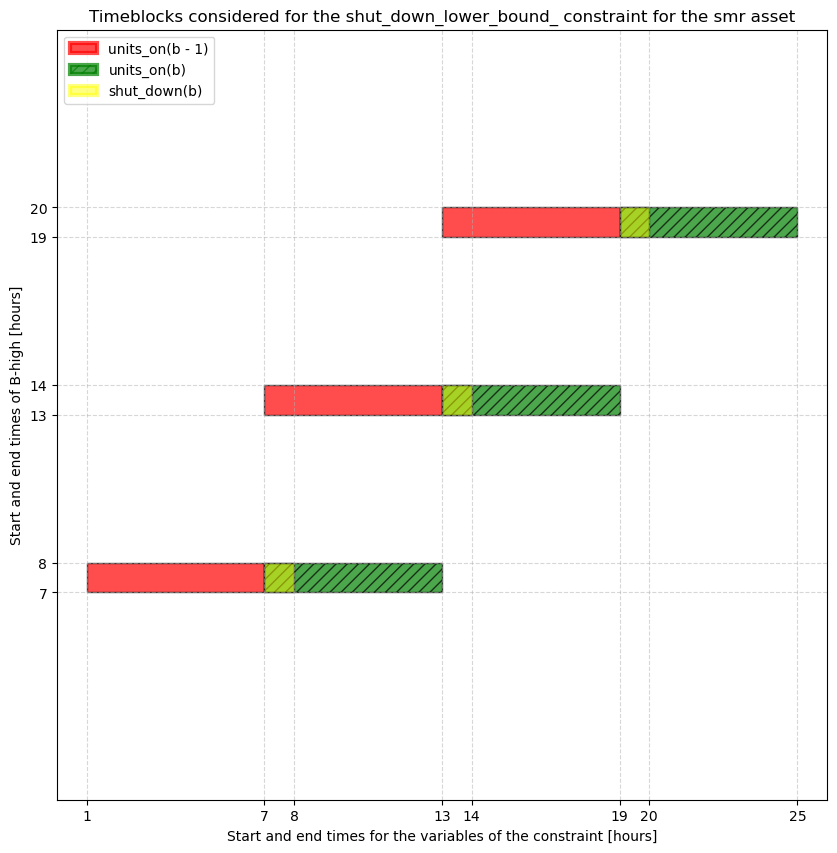

In [16]:
labels = ["units_on(b - 1)", "units_on(b)", "shut_down(b)"]

plot_constraints(asset_times_map, constraint_name)